# Correlations and Chi squared

This script finds the correlations between numerical features of the EPC data and performs a chi-squared test on all EPC variables

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import glob
import json
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set variables from config file
config_path = os.path.abspath('..')

with open(config_path + '/config.json', 'r') as f:
    config = json.load(f)

processing_path = config['DEFAULT']['processing_path']
epc_train_fname = config['DEFAULT']['epc_train_fname']
epc_test_fname = config['DEFAULT']['epc_test_fname']

In [3]:
dtype_dict = {'INSPECTION_DATE':'str'}

epc_train = pd.read_csv(os.path.join(processing_path,epc_train_fname),
                        header = 0,
                        delimiter = ',',
                        dtype = dtype_dict,
                        parse_dates = ['INSPECTION_DATE'])

epc_test = pd.read_csv(os.path.join(processing_path,epc_test_fname),
                        header = 0,
                        delimiter = ',',
                        dtype = dtype_dict,
                        parse_dates = ['INSPECTION_DATE'])

In [4]:
#Numeric
var_list_num = epc_train.select_dtypes(include= 'number').columns.tolist()
var_list_num.remove('BUILDING_REFERENCE_NUMBER')

#Categorical
var_list_cat = epc_train.select_dtypes(include= ['object','category']).columns.tolist()
var_list_cat.remove('LMK_KEY')
var_list_cat.remove('POSTCODE')
var_list_cat.remove('CURRENT_ENERGY_RATING')

### Numeric features correrlations against the other fields in the taxonomy  

<ipython-input-5-39cadd7d8810>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_energy_costs, dtype=np.bool)


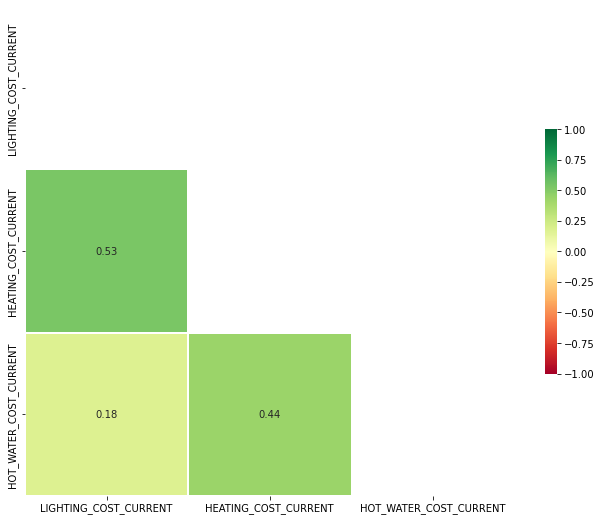

In [5]:
corr_energy_costs = epc_train[['LIGHTING_COST_CURRENT',
                               'HEATING_COST_CURRENT',
                               'HOT_WATER_COST_CURRENT']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_energy_costs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_energy_costs, mask=mask, cmap='RdYlGn', vmin = -1, vmax=1, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

<ipython-input-6-219912e5420e>:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_house_desc, dtype=np.bool)


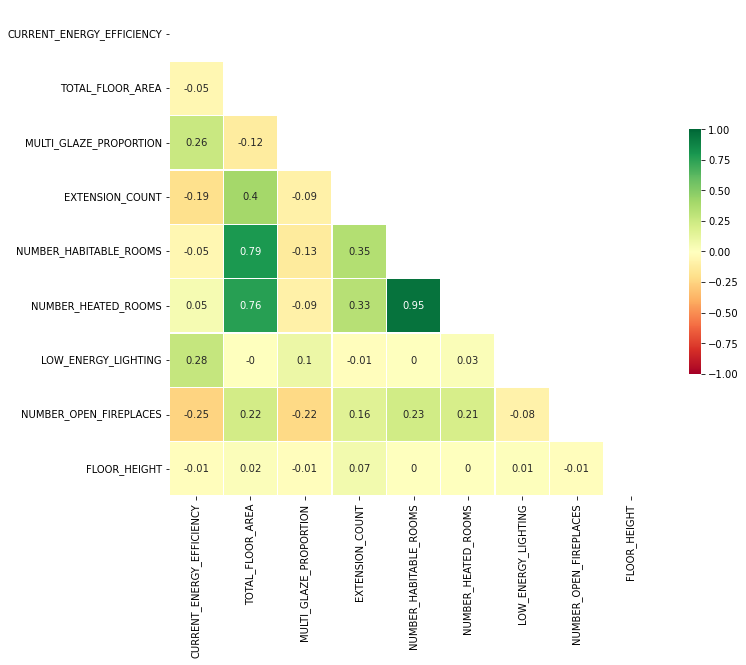

In [6]:
#House descriptions
corr_house_desc = epc_train[[ 'CURRENT_ENERGY_EFFICIENCY',
                            'TOTAL_FLOOR_AREA',
                            'MULTI_GLAZE_PROPORTION',
                            'EXTENSION_COUNT',
                            'NUMBER_HABITABLE_ROOMS',
                            'NUMBER_HEATED_ROOMS',
                            'LOW_ENERGY_LIGHTING',
                            'NUMBER_OPEN_FIREPLACES',
                            'FLOOR_HEIGHT']].corr()
# plot correlations
corr_house_desc = round(corr_house_desc,2)
mask = np.zeros_like(corr_house_desc, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_house_desc, mask=mask, cmap='RdYlGn', vmin = -1, vmax=1, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

<ipython-input-7-8b1eba5d976d>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_all, dtype=np.bool)


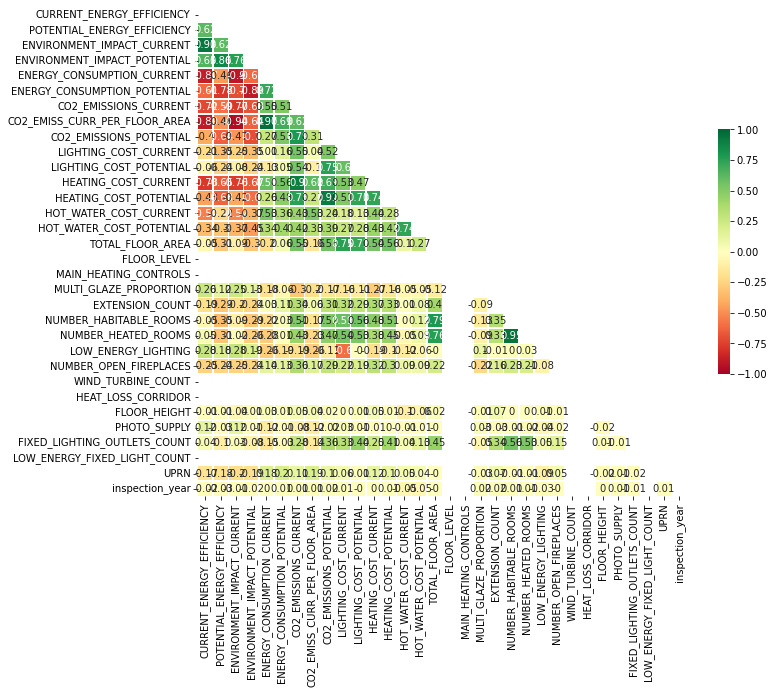

In [7]:
corr_all = epc_train[var_list_num].corr()

# plot correlations
corr_all = round(corr_all,2)
mask = np.zeros_like(corr_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_all, mask=mask, cmap='RdYlGn', vmin = -1, vmax=1, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

### Categorical features Chi-Squared test of independence between variables in taxonomy
if Chi-squared > crit_value reject the null hypothesis that there is no relationship between both variables        Uplift is a measure of the uplift between the chi squared metric and the critical value (I am assuming that the larger the uplift. The stronger the relastionship between the features (I am not 100% about this so I am checking with Gareth)

In [8]:
#Function to run a series of chi-squared independance tests for all the
#possible combinations of a variable within a dataframe

def get_chi_squared_all(df):
    
    ''' 
    Performs a chi-squared test between all variables in the dataframe
    Parameters
      df: a dataframe
    Returns a dataframe
    '''
    
    results_buffer = {}
    for var1 in df.columns.values:
        for var2 in df.columns.values:
            if(var1 != var2):
                xtab = pd.crosstab(df[var1],df[var2])
                res = stats.chi2_contingency(xtab)
                chi_squred_crit_value = stats.chi2.ppf(q = 0.95,df = res[2])
                #TODO I don't think printing all this is helpful, it's too fast to see
                print("\nResults for %s and %s" % (var1, var2))
                print("\tChi-squared:\t%f" % res[0])
                print("\tP-value:\t%f" % res[1])
                print("\tDoF:\t\t%i" % res[2])
                print("\tCrit-value:\t%f" % chi_squred_crit_value)
                print("\tUplift:\t\t%f" % (res[0] / chi_squred_crit_value))
                results_buffer[(var1, var2)] = (res[0] / chi_squred_crit_value)
    return pd.Series(results_buffer, name = 'uplift').sort_values(ascending = False)

chi2_all = get_chi_squared_all(epc_train[var_list_cat])


Results for ADDRESS1 and ADDRESS2
	Chi-squared:	1725460.000000
	P-value:	0.420499
	DoF:		1725088
	Crit-value:	1728144.394548
	Uplift:		0.998447

Results for ADDRESS1 and ADDRESS3
	Chi-squared:	40838.333333
	P-value:	0.125954
	DoF:		40512
	Crit-value:	40981.337166
	Uplift:		0.996511

Results for ADDRESS1 and POTENTIAL_ENERGY_RATING
	Chi-squared:	15880.974293
	P-value:	0.496327
	DoF:		15880
	Crit-value:	16174.267501
	Uplift:		0.981867

Results for ADDRESS1 and PROPERTY_TYPE
	Chi-squared:	0.000000
	P-value:	1.000000
	DoF:		0
	Crit-value:	nan
	Uplift:		nan

Results for ADDRESS1 and BUILT_FORM
	Chi-squared:	19886.779244
	P-value:	0.425508
	DoF:		19850
	Crit-value:	20178.867847
	Uplift:		0.985525

Results for ADDRESS1 and LOCAL_AUTHORITY
	Chi-squared:	1287893.581326
	P-value:	0.157203
	DoF:		1286280
	Crit-value:	1288919.350494
	Uplift:		0.999204

Results for ADDRESS1 and CONSTITUENCY
	Chi-squared:	2244144.962157
	P-value:	0.302508
	DoF:		2243050
	Crit-value:	2246535.004981
	Uplift:		0.99893


Results for ADDRESS2 and FLOOR_DESCRIPTION
	Chi-squared:	36985.267265
	P-value:	0.000000
	DoF:		33263
	Crit-value:	33688.385068
	Uplift:		1.097864

Results for ADDRESS2 and WINDOWS_DESCRIPTION
	Chi-squared:	17003.493197
	P-value:	0.000000
	DoF:		14898
	Crit-value:	15183.059177
	Uplift:		1.119899

Results for ADDRESS2 and WINDOWS_ENERGY_EFF
	Chi-squared:	5386.180921
	P-value:	0.000000
	DoF:		4584
	Crit-value:	4742.623003
	Uplift:		1.135697

Results for ADDRESS2 and WINDOWS_ENV_EFF
	Chi-squared:	5386.180921
	P-value:	0.000000
	DoF:		4584
	Crit-value:	4742.623003
	Uplift:		1.135697

Results for ADDRESS2 and WALLS_DESCRIPTION
	Chi-squared:	61158.538059
	P-value:	0.000000
	DoF:		51615
	Crit-value:	52144.616609
	Uplift:		1.172864

Results for ADDRESS2 and WALLS_ENERGY_EFF
	Chi-squared:	5313.907024
	P-value:	0.000000
	DoF:		4588
	Crit-value:	4746.691707
	Uplift:		1.119497

Results for ADDRESS2 and WALLS_ENV_EFF
	Chi-squared:	5313.907024
	P-value:	0.000000
	DoF:		4588
	Crit-value:	4746.691707


Results for ADDRESS3 and LIGHTING_DESCRIPTION
	Chi-squared:	10495.511111
	P-value:	0.000000
	DoF:		9792
	Crit-value:	10023.316905
	Uplift:		1.047110

Results for ADDRESS3 and LIGHTING_ENERGY_EFF
	Chi-squared:	836.308833
	P-value:	0.043571
	DoF:		768
	Crit-value:	833.581680
	Uplift:		1.003272

Results for ADDRESS3 and LIGHTING_ENV_EFF
	Chi-squared:	836.308833
	P-value:	0.043571
	DoF:		768
	Crit-value:	833.581680
	Uplift:		1.003272

Results for ADDRESS3 and MAIN_FUEL
	Chi-squared:	2084.554545
	P-value:	0.004745
	DoF:		1920
	Crit-value:	2023.052151
	Uplift:		1.030401

Results for ADDRESS3 and MECHANICAL_VENTILATION
	Chi-squared:	0.000000
	P-value:	1.000000
	DoF:		0
	Crit-value:	nan
	Uplift:		nan

Results for ADDRESS3 and ADDRESS
	Chi-squared:	41088.000000
	P-value:	0.250592
	DoF:		40896
	Crit-value:	41367.550916
	Uplift:		0.993242

Results for ADDRESS3 and LOCAL_AUTHORITY_LABEL
	Chi-squared:	24804.000000
	P-value:	0.000000
	DoF:		22230
	Crit-value:	22577.959572
	Uplift:		1.098594

Result


Results for POTENTIAL_ENERGY_RATING and LODGEMENT_DATETIME
	Chi-squared:	15642.484106
	P-value:	0.149749
	DoF:		15460
	Crit-value:	15750.364996
	Uplift:		0.993151

Results for POTENTIAL_ENERGY_RATING and TENURE
	Chi-squared:	2270.577171
	P-value:	0.000000
	DoF:		12
	Crit-value:	21.026070
	Uplift:		107.988663

Results for POTENTIAL_ENERGY_RATING and UPRN_SOURCE
	Chi-squared:	87.446889
	P-value:	0.000000
	DoF:		4
	Crit-value:	9.487729
	Uplift:		9.216841

Results for POTENTIAL_ENERGY_RATING and region
	Chi-squared:	0.000000
	P-value:	1.000000
	DoF:		0
	Crit-value:	nan
	Uplift:		nan

Results for PROPERTY_TYPE and ADDRESS1
	Chi-squared:	0.000000
	P-value:	1.000000
	DoF:		0
	Crit-value:	nan
	Uplift:		nan

Results for PROPERTY_TYPE and ADDRESS2
	Chi-squared:	0.000000
	P-value:	1.000000
	DoF:		0
	Crit-value:	nan
	Uplift:		nan

Results for PROPERTY_TYPE and ADDRESS3
	Chi-squared:	0.000000
	P-value:	1.000000
	DoF:		0
	Crit-value:	nan
	Uplift:		nan

Results for PROPERTY_TYPE and POTENTIAL_ENERGY


Results for BUILT_FORM and WALLS_DESCRIPTION
	Chi-squared:	946.956203
	P-value:	0.000000
	DoF:		240
	Crit-value:	277.137650
	Uplift:		3.416916

Results for BUILT_FORM and WALLS_ENERGY_EFF
	Chi-squared:	391.156007
	P-value:	0.000000
	DoF:		20
	Crit-value:	31.410433
	Uplift:		12.453060

Results for BUILT_FORM and WALLS_ENV_EFF
	Chi-squared:	391.156007
	P-value:	0.000000
	DoF:		20
	Crit-value:	31.410433
	Uplift:		12.453060

Results for BUILT_FORM and SECONDHEAT_DESCRIPTION
	Chi-squared:	294.870926
	P-value:	0.000000
	DoF:		55
	Crit-value:	73.311493
	Uplift:		4.022165

Results for BUILT_FORM and ROOF_DESCRIPTION
	Chi-squared:	668.400762
	P-value:	0.000000
	DoF:		240
	Crit-value:	277.137650
	Uplift:		2.411801

Results for BUILT_FORM and ROOF_ENERGY_EFF
	Chi-squared:	155.509788
	P-value:	0.000000
	DoF:		20
	Crit-value:	31.410433
	Uplift:		4.950896

Results for BUILT_FORM and ROOF_ENV_EFF
	Chi-squared:	155.509788
	P-value:	0.000000
	DoF:		20
	Crit-value:	31.410433
	Uplift:		4.950896

Results


Results for LOCAL_AUTHORITY and LIGHTING_DESCRIPTION
	Chi-squared:	36176.865362
	P-value:	0.000000
	DoF:		29808
	Crit-value:	30210.747653
	Uplift:		1.197483

Results for LOCAL_AUTHORITY and LIGHTING_ENERGY_EFF
	Chi-squared:	1724.378751
	P-value:	0.000000
	DoF:		1296
	Crit-value:	1380.863795
	Uplift:		1.248768

Results for LOCAL_AUTHORITY and LIGHTING_ENV_EFF
	Chi-squared:	1724.378751
	P-value:	0.000000
	DoF:		1296
	Crit-value:	1380.863795
	Uplift:		1.248768

Results for LOCAL_AUTHORITY and MAIN_FUEL
	Chi-squared:	8726.006711
	P-value:	0.000000
	DoF:		5508
	Crit-value:	5681.768652
	Uplift:		1.535791

Results for LOCAL_AUTHORITY and MECHANICAL_VENTILATION
	Chi-squared:	380.673761
	P-value:	1.000000
	DoF:		648
	Crit-value:	708.329773
	Uplift:		0.537424

Results for LOCAL_AUTHORITY and ADDRESS
	Chi-squared:	1291911.622549
	P-value:	0.247584
	DoF:		1290816
	Crit-value:	1293459.998163
	Uplift:		0.998803

Results for LOCAL_AUTHORITY and LOCAL_AUTHORITY_LABEL
	Chi-squared:	1271256.000000
	P-v


Results for CONSTITUENCY and LODGEMENT_DATETIME
	Chi-squared:	2203565.939468
	P-value:	0.000000
	DoF:		2183725
	Crit-value:	2187163.624945
	Uplift:		1.007499

Results for CONSTITUENCY and TENURE
	Chi-squared:	3912.846577
	P-value:	0.000000
	DoF:		1695
	Crit-value:	1791.892952
	Uplift:		2.183639

Results for CONSTITUENCY and UPRN_SOURCE
	Chi-squared:	829.952671
	P-value:	0.000000
	DoF:		565
	Crit-value:	621.406001
	Uplift:		1.335605

Results for CONSTITUENCY and region
	Chi-squared:	0.000000
	P-value:	1.000000
	DoF:		0
	Crit-value:	nan
	Uplift:		nan


KeyboardInterrupt: 

In [ ]:
#Function to run a series of chi-squared independance tests for all the
#features against the target
def get_chi_squared_target(df,target,feature_list):
    
    ''' 
    Performs a chi-squared test between specified variables in the dataframe
    Parameters
      df: a dataframe
      target: string, a variable you want to be in every chi-squared
      feature_list: list, the other variables you want to test the target with
    Returns a dataframe
    '''
    
    results_buffer = {}
    for var in feature_list:
        xtab = pd.crosstab(df[target],df[var])
        res = stats.chi2_contingency(xtab)
        chi_squred_crit_value = stats.chi2.ppf(q = 0.95,df = res[2])
        print("\nResults for %s and %s" % (target, var))
        print("\tChi-squared:\t%f" % res[0])
        print("\tP-value:\t%f" % res[1])
        print("\tDoF:\t\t%i" % res[2])
        print("\tCrit-value:\t%f" % chi_squred_crit_value)
        print("\tUplift:\t\t%f" % (res[0] / chi_squred_crit_value))
        results_buffer[var] = (res[0] / chi_squred_crit_value)
    return pd.Series(results_buffer, name = 'uplift').sort_values(ascending = False)


chi2_target = get_chi_squared_target(epc_train,'CURRENT_ENERGY_RATING',var_list_cat)
